# Iris area extraction

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from faceparsing.parser import FaceParser
from imagine.shape.segment import ParsingSegmenter
from imagine.color import conversion
from imagine.color.extract import MedianColorExtractor
from imagine.shape import operations
from automakeup.feature import face
from automakeup.face import extract as face_extraction, bounding
from mtcnn import MTCNN

In [2]:
parser = FaceParser()

In [3]:
mtcnn = MTCNN()

In [4]:
face_extractor = face_extraction.SimpleFaceExtractor(512, interpolation=cv2.INTER_CUBIC, bb_scale=1.0)
bb_finder = bounding.MTCNNBoundingBoxFinder(mtcnn)

In [5]:
def crop_to_eye(img, parser):
    eyes_mask = ParsingSegmenter(parser, parts_map={"l_eye": 1, "r_eye": 1})(img) == 1
    biggest_eye_contour = operations.biggest_contour(eyes_mask)
    eye_rect = operations.bounding_rect(biggest_eye_contour)
    eye_rect_square = operations.safe_rect(operations.squarisize(eye_rect), img.shape, allow_scaling=True)
    crop = operations.Crop(eye_rect_square)
    img_cropped = crop(img)
    eye_mask_cropped = crop(np.array(eyes_mask, dtype=np.uint8))
    eye_mask_cropped = operations.Erode(max(1, round(0.1 * eye_rect.height())))(eye_mask_cropped)
    return img_cropped, eye_mask_cropped != 0

In [6]:
def show_colorspace(eye, mask):
    eye_pixels = eye[mask]
    eye_lab = conversion.RgbToLab(eye)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(2, 3, 1, title="Image cropped to eye with eye mask")
    ax.imshow(np.where(mask[...,None], eye, 0))
    ax.set_axis_off()
    ax = fig.add_subplot(2, 3, 2, title="L channel in LAB color space")
    ax.imshow(np.where(mask, eye_lab[..., 0], 0), cmap='gray')
    ax.set_axis_off()
    ax = fig.add_subplot(2, 3, 3, title="L channel histogram", xlabel="L")
    ax.hist(eye_lab[mask][..., 0], bins=64)
    ax = fig.add_subplot(2, 3, 4, title="LAB color space", projection='3d', 
                         xlabel="A", ylabel="B", zlabel="L")
    eye_lab_pixels = eye_lab[mask]
    ax.scatter(eye_lab_pixels[..., 1], eye_lab_pixels[..., 2], eye_lab_pixels[..., 0], facecolors=eye_pixels/255.)
    ax = fig.add_subplot(2, 3, 5, xlabel="A", ylabel="L", ylim=[0,255])
    ax.scatter(eye_lab_pixels[..., 1], eye_lab_pixels[..., 0], facecolors=eye_pixels/255.)
    ax = fig.add_subplot(2, 3, 6, xlabel="B", ylabel="L", ylim=[0,255])
    ax.scatter(eye_lab_pixels[..., 2], eye_lab_pixels[..., 0], facecolors=eye_pixels/255.)
    plt.tight_layout()
    plt.show()

### Colorspace exploration

In [7]:
image_paths = ["faces/" + f for f in os.listdir("faces")]

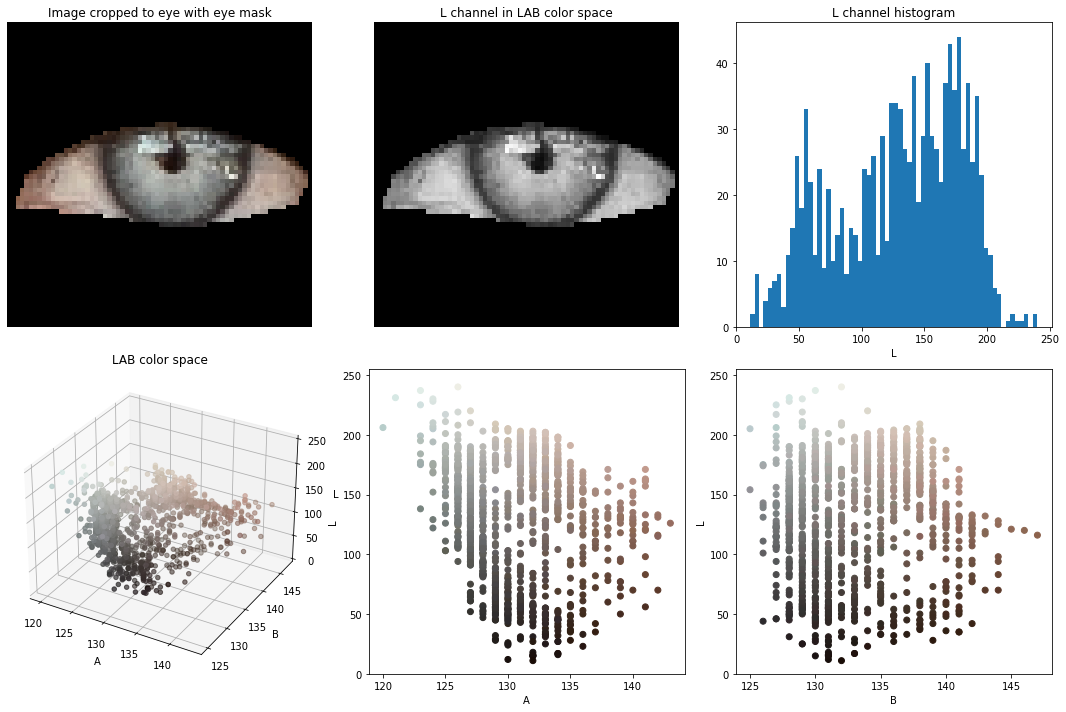

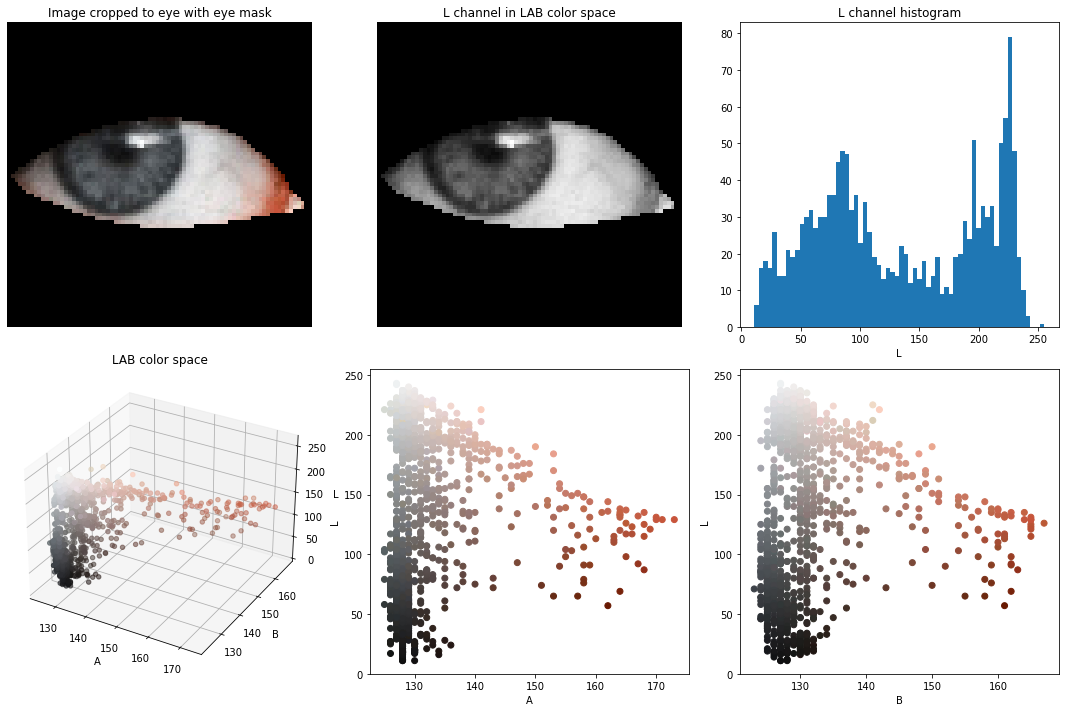

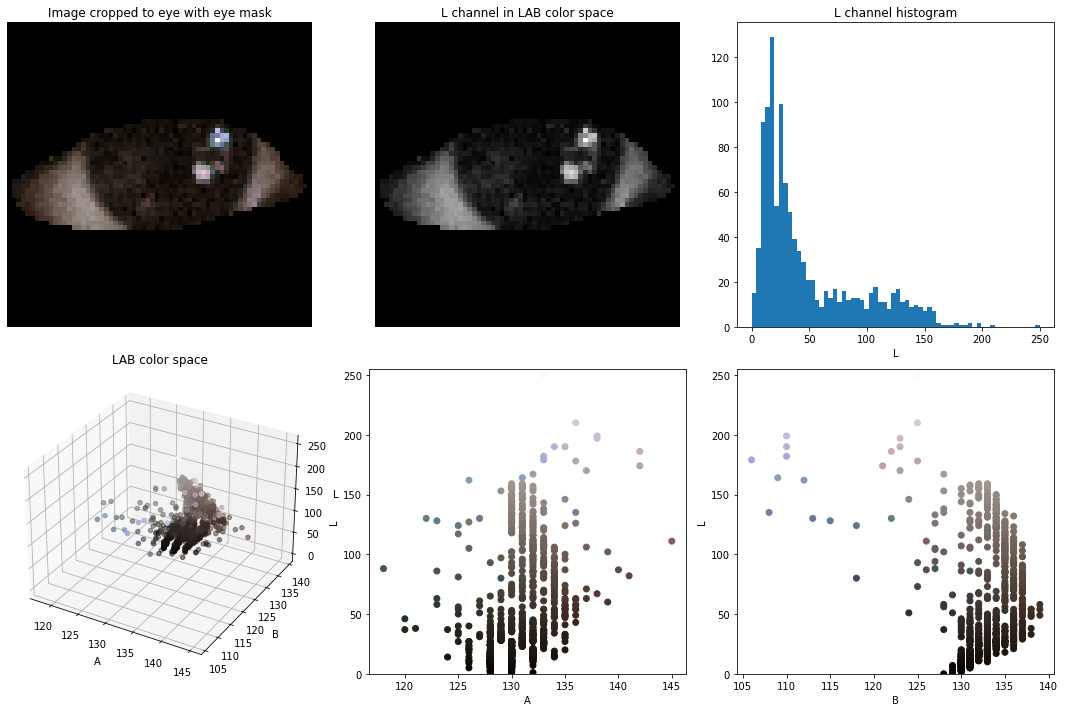

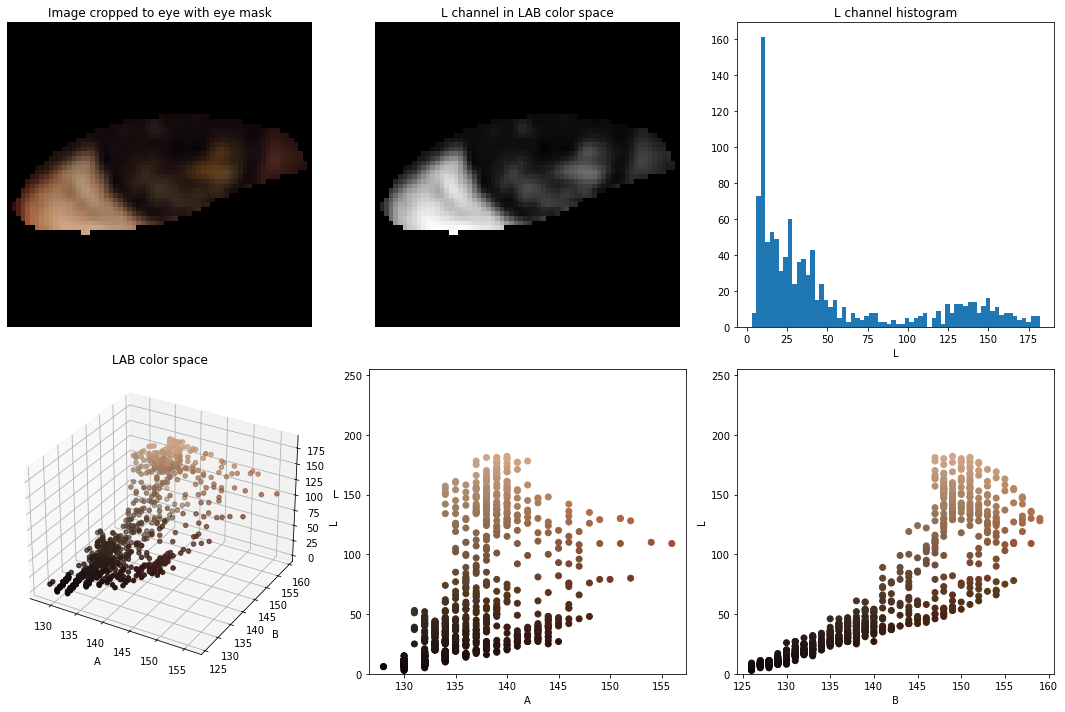

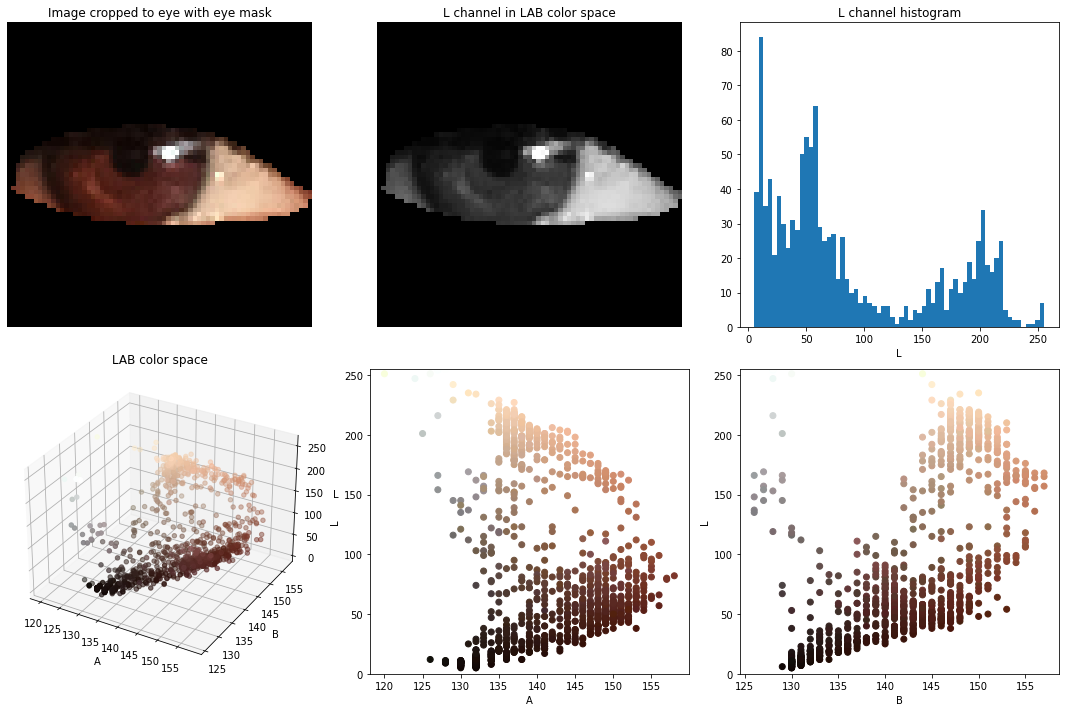

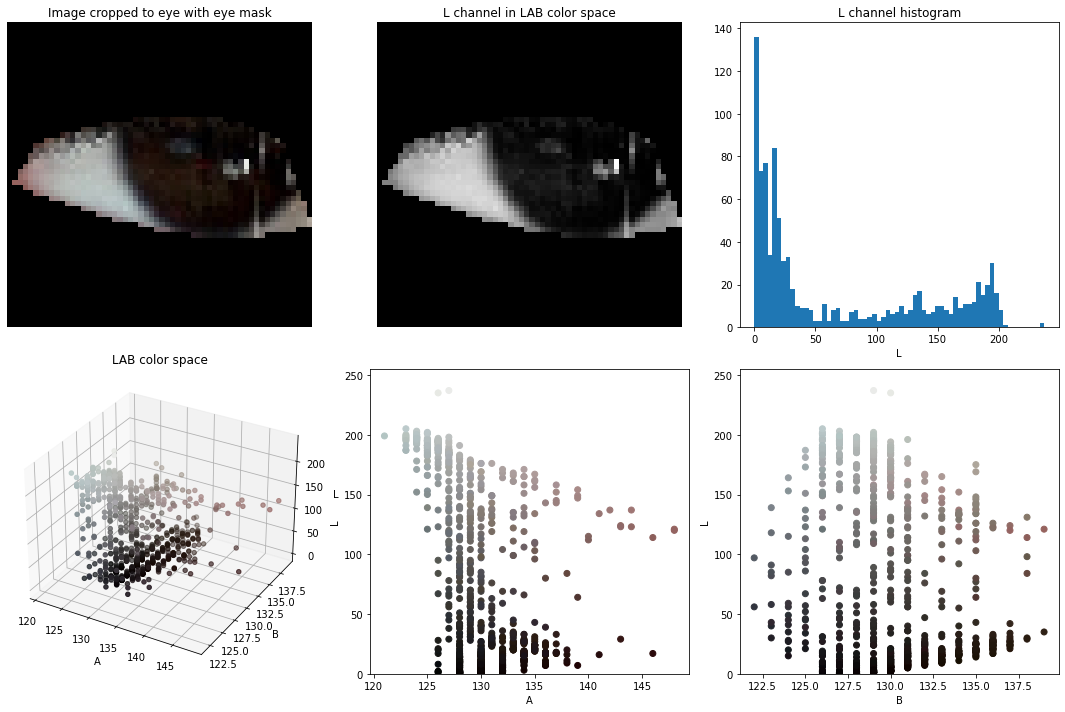

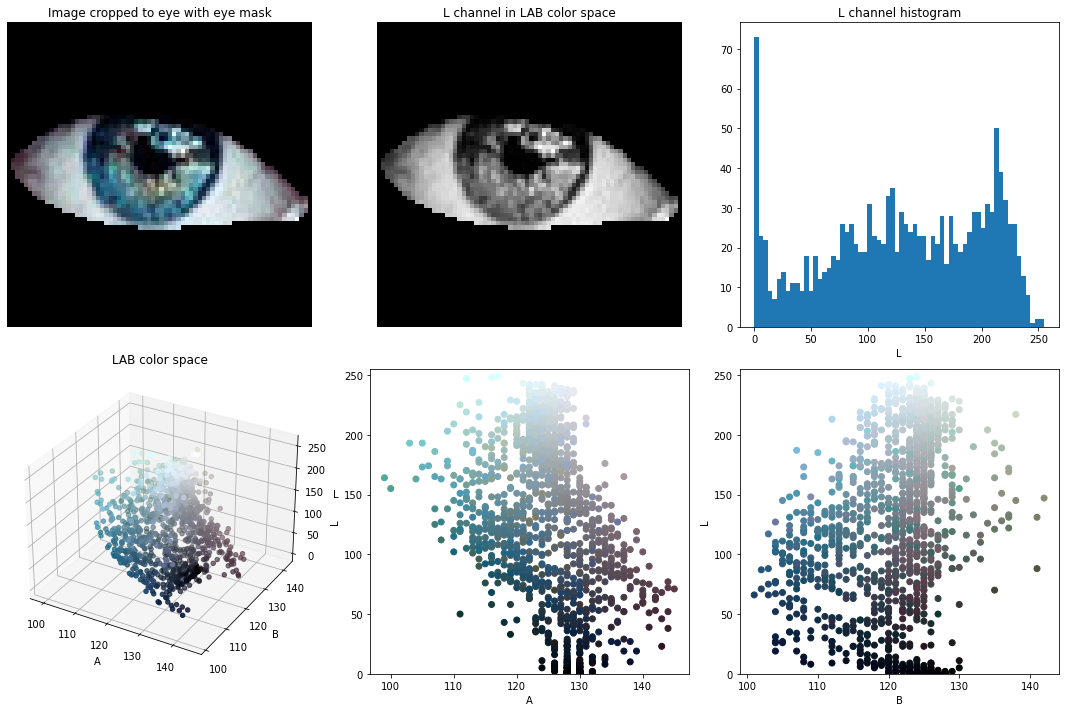

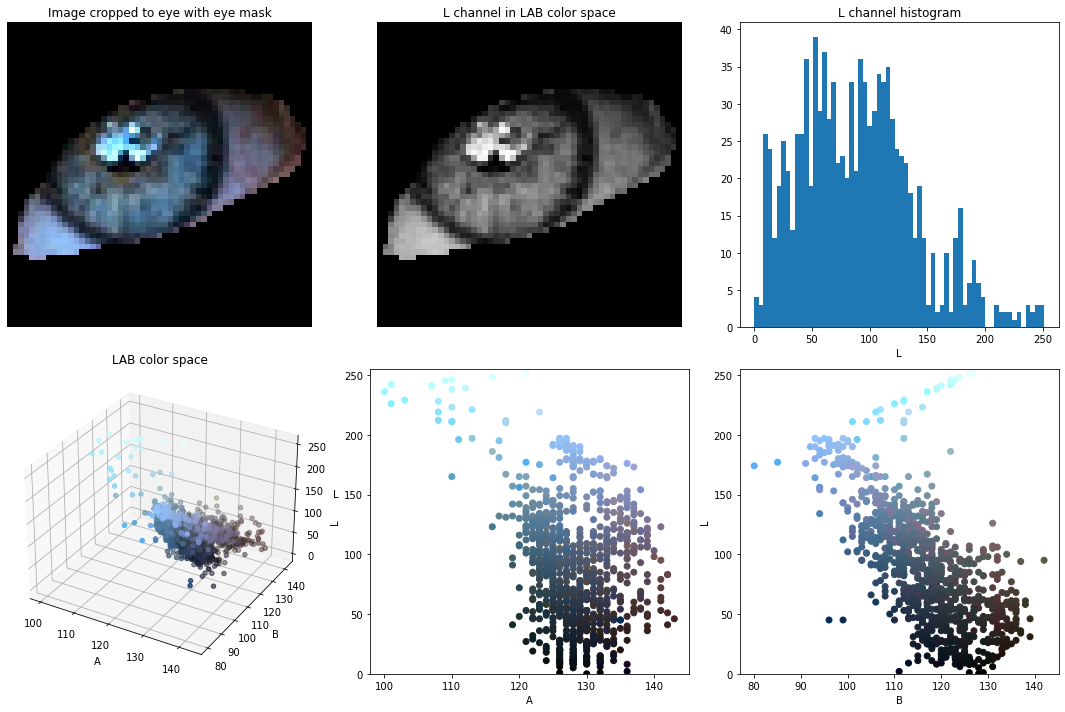

In [8]:
for path in image_paths:
    image = conversion.BgrToRgb(cv2.imread(path))
    bb = bb_finder.find(image)
    image = face_extractor.extract(image, bb)
    eye, mask = crop_to_eye(image, parser)
    show_colorspace(eye, mask)

### Comparison of extraction methods

In [9]:
def show_iris(eye, mask, extractor, color_extractor):
    iris_mask = extractor.extract(eye, mask)
    color = color_extractor.extract(eye, iris_mask)
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    axs[0].imshow(eye)
    axs[0].title.set_text("Image cropped to eye")
    axs[0].set_axis_off()
    axs[1].imshow(np.where(mask[...,None], eye, 0))
    axs[1].title.set_text("Search area")
    axs[1].set_axis_off()
    axs[2].imshow(iris_mask, cmap="gray")
    axs[2].title.set_text("Iris mask")
    axs[2].set_axis_off()
    axs[3].imshow(np.where(iris_mask[...,None], eye, 0))
    axs[3].title.set_text("Mask applied to image")
    axs[3].set_axis_off()
    axs[4].imshow([color])
    axs[4].title.set_text("Extracted color")
    axs[4].set_axis_off()
    plt.tight_layout()
    plt.show()

In [10]:
image_paths = ["faces/" + f for f in os.listdir("faces")]

In [11]:
color_extractor = MedianColorExtractor()

##### Thresholding

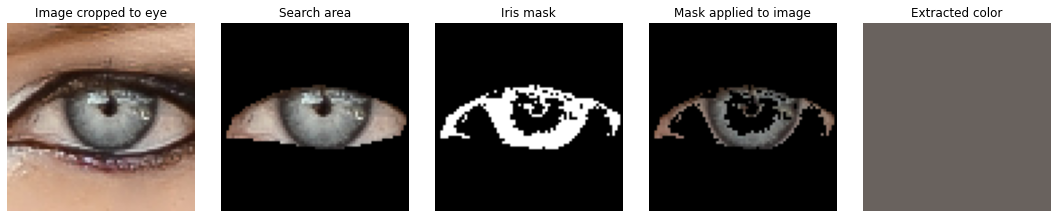

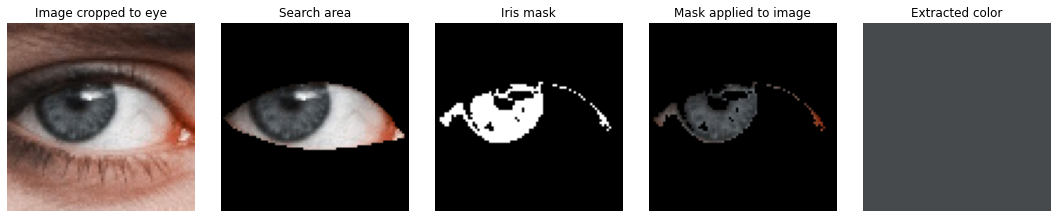

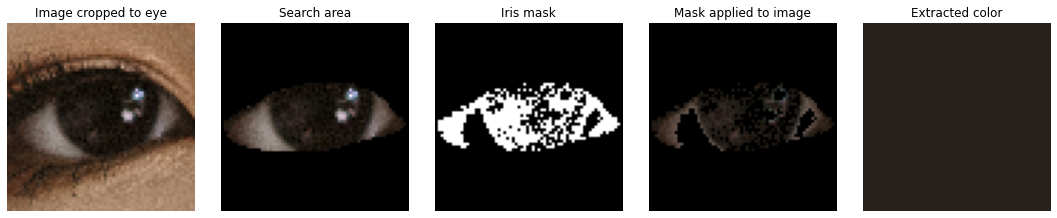

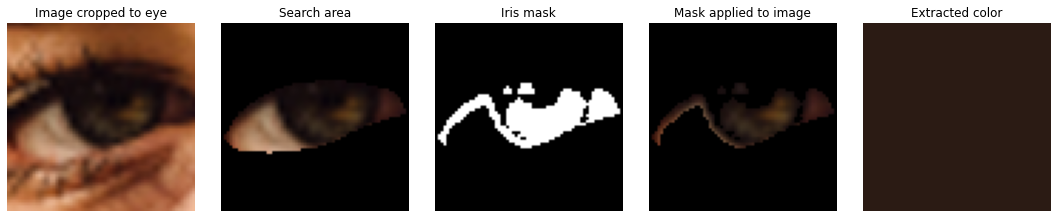

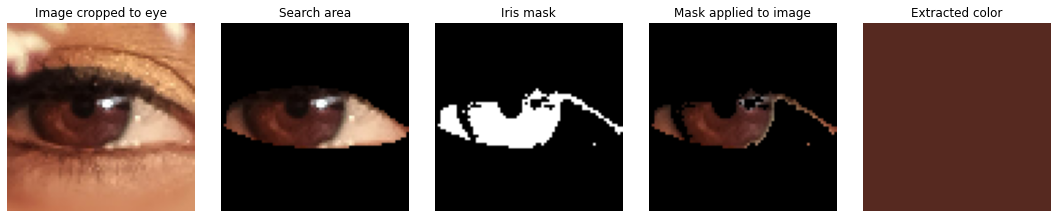

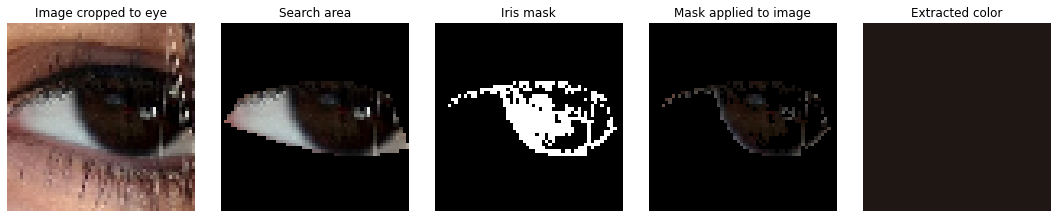

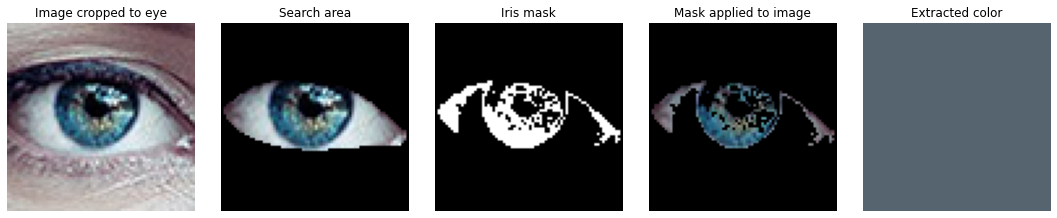

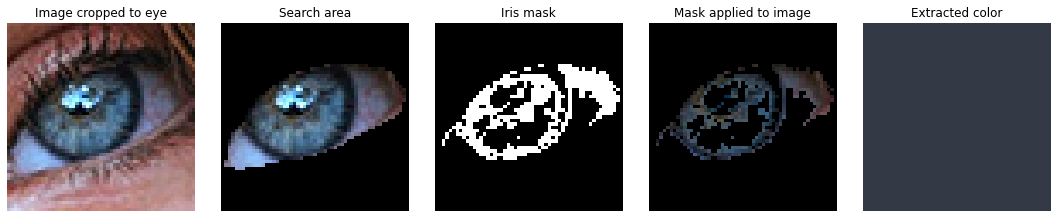

In [12]:
extractor = face.ThresholdingIrisShapeExtractor()

for path in image_paths:
    image = conversion.BgrToRgb(cv2.imread(path))
    bb = bb_finder.find(image)
    image = face_extractor.extract(image, bb)
    eye, mask = crop_to_eye(image, parser)
    show_iris(eye, mask, extractor, color_extractor)

##### Clustering

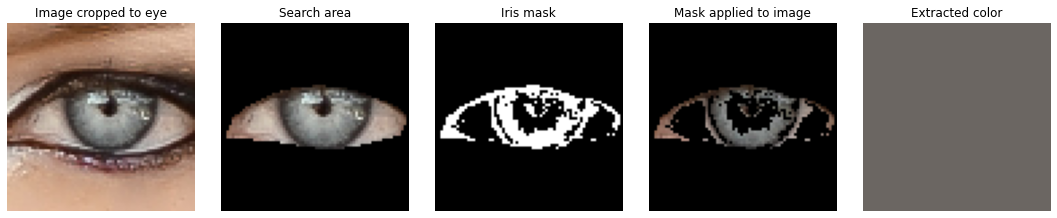

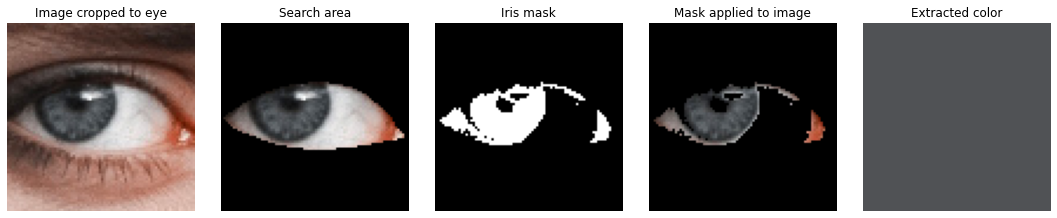

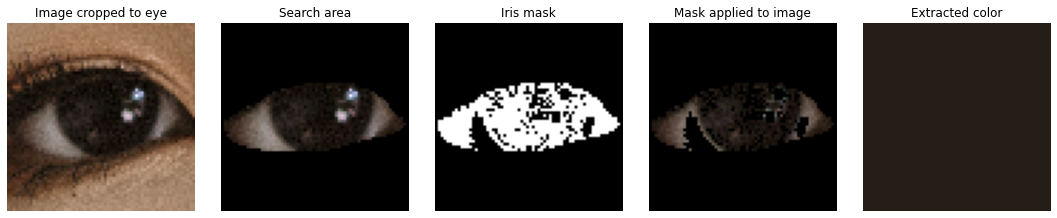

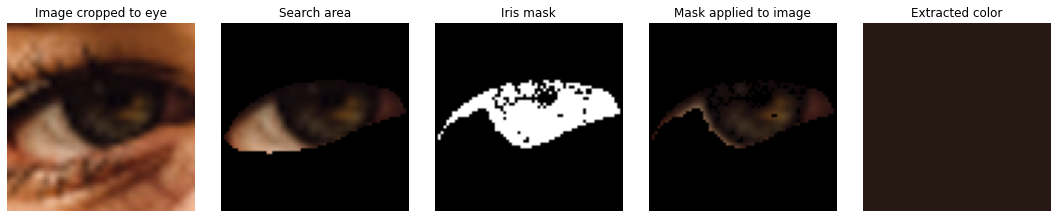

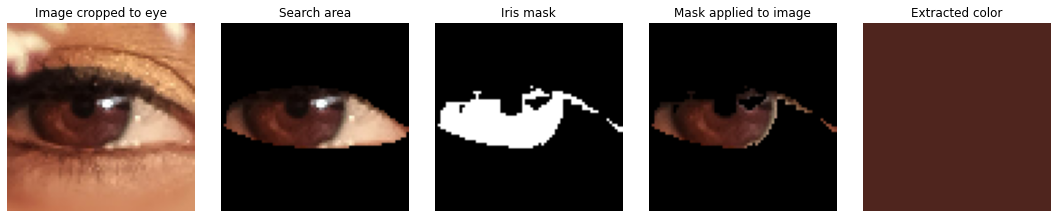

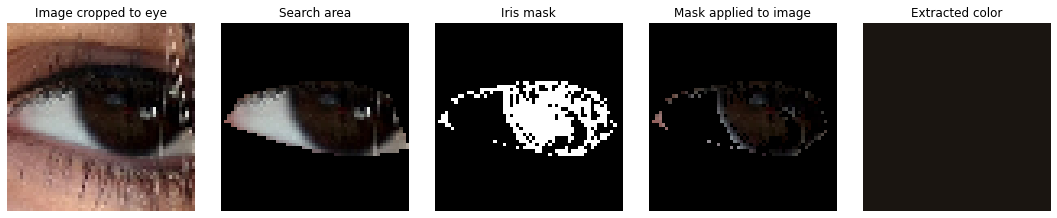

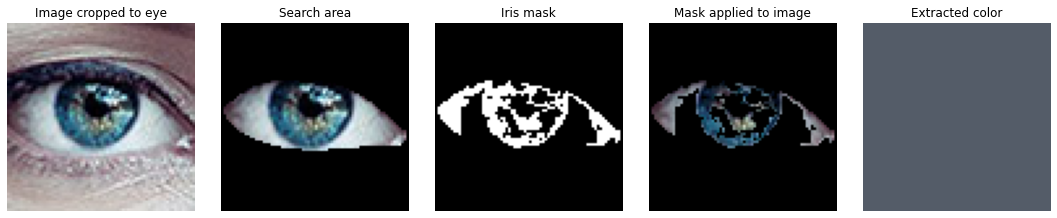

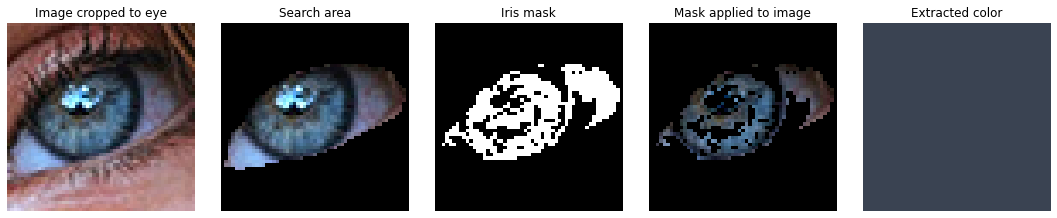

In [13]:
extractor = face.ClusteringIrisShapeExtractor()

for path in image_paths:
    image = conversion.BgrToRgb(cv2.imread(path))
    bb = bb_finder.find(image)
    image = face_extractor.extract(image, bb)
    eye, mask = crop_to_eye(image, parser)
    show_iris(eye, mask, extractor, color_extractor)

##### Hough circles

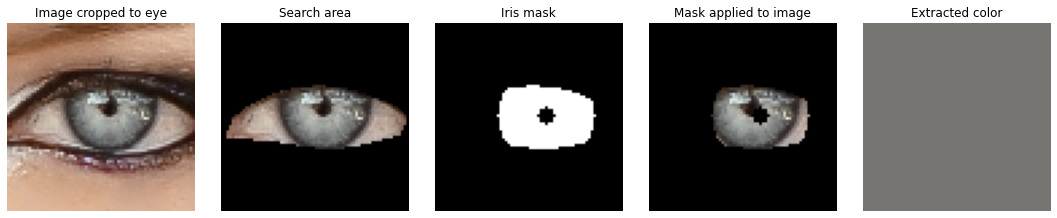

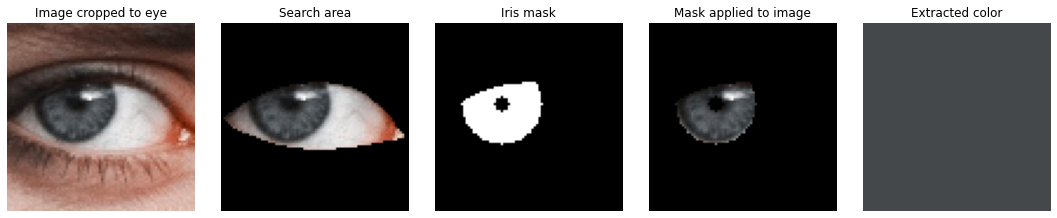

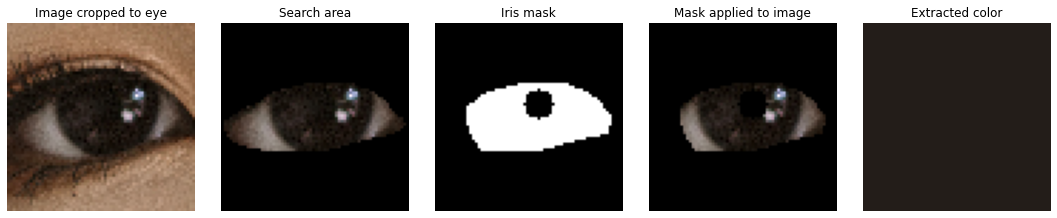

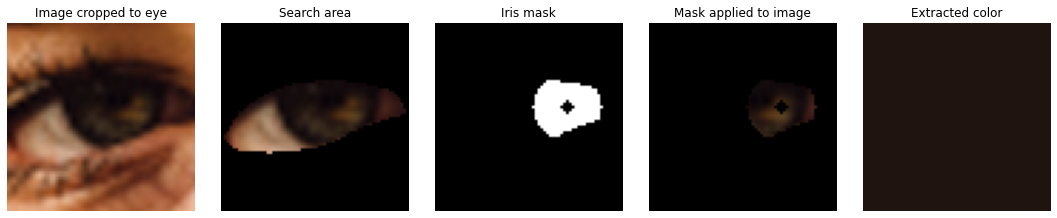

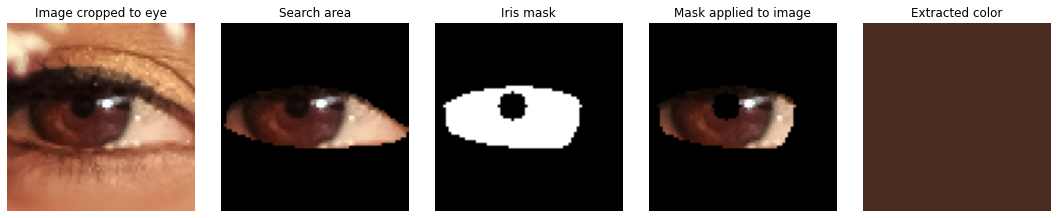

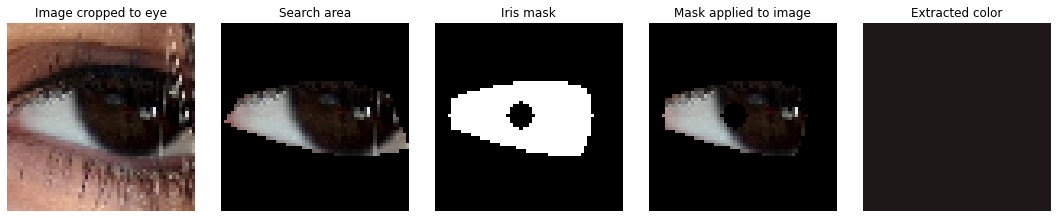

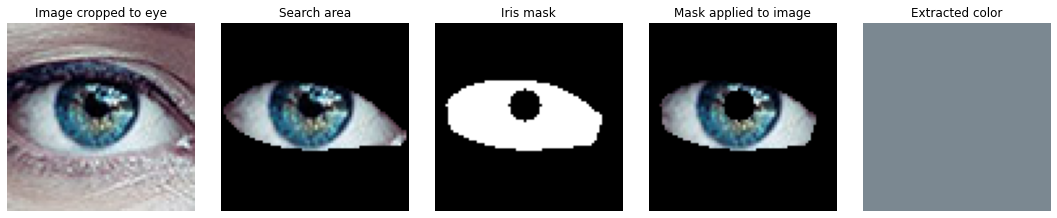

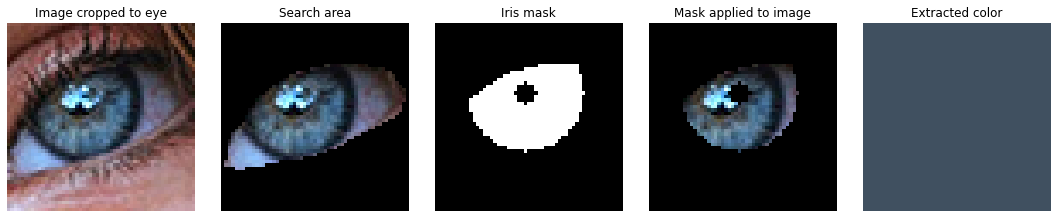

In [14]:
extractor = face.HoughCircleIrisShapeExtractor()
for path in image_paths:
    image = conversion.BgrToRgb(cv2.imread(path))
    bb = bb_finder.find(image)
    image = face_extractor.extract(image, bb)
    eye, mask = crop_to_eye(image, parser)
    show_iris(eye, mask, extractor, color_extractor)